#### TFX Pipelines:

MLOps is the practice of applying DevOps practices to help automate, manage, and audit machine learning (ML) workflows. ML workflows include steps to:

    Prepare, analyze, and transform data.

    Train and evaluate a model.

    Deploy trained models to production.

    Track ML artifacts and understand their dependencies.
    
By implementing your workflow as a TFX pipeline, you can:

    Automate your ML process, which lets you regularly retrain, evaluate, and deploy your model.

    Utilize distributed compute resources for processing large datasets and workloads.

    Increase the velocity of experimentation by running a pipeline with different sets of hyperparameters.


###### Pipeline
A TFX pipeline is a portable implementation of an ML workflow that can be run on various orchestrators, such as: Apache Airflow, Apache Beam, and Kubeflow Pipelines. A pipeline is composed of component instances and input parameters.

###### Component
A component is an implementation of an ML task that you can use as a step in your TFX pipeline. Components are composed of:

    A component specification, which defines the component's input and output artifacts, and the component's 
    required parameters.

    An executor, which implements the code to perform a step in your ML workflow, such as ingesting and 
    transforming data or training and evaluating a model.

    A component interface, which packages the component specification and executor for use in a pipeline.
    
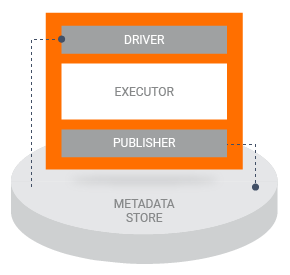


###### Parameter
Parameters are inputs to pipelines that are known before your pipeline is executed. Parameters let you change the behavior of a pipeline, or a part of a pipeline, through configuration instead of code.

For example, you can use parameters to run a pipeline with different sets of hyperparameters without changing the pipeline's code.

###### Artifact
The outputs of steps in a TFX pipeline are called artifacts. Subsequent steps in your workflow may use these artifacts as inputs. In this way, TFX lets you transfer data between workflow steps.



####  TFX Components

    1. ExampleGen
    2. StatisticsGen
    3. SchemaGen
    4. ExampleValidator
    5. Transform
    6. Trainer
    7. Tuner
    8. Evaluator
    9. InfraValidator
    10.Pusher
    11.BulkInferrer

In [1]:
import os
import tempfile
import time

import tensorflow as tf
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma
import tensorflow_transform as tft
import tfx

from pprint import pprint
from tensorflow_metadata.proto.v0 import schema_pb2, statistics_pb2, anomalies_pb2
from tensorflow_transform.tf_metadata import schema_utils
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import InfraValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.common_nodes.importer_node import ImporterNode
from tfx.components.trainer import executor as trainer_executor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import evaluator_pb2
from tfx.proto import example_gen_pb2
from tfx.proto import infra_validator_pb2
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.proto.evaluator_pb2 import SingleSlicingSpec
from tfx.utils.dsl_utils import external_input
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.types.standard_artifacts import InfraBlessing

##### Creating Interactive Context

TFX Interactive Context allows you to create and run TFX Components in an interactive mode. It is designed to support experimentation and development in a Jupyter Notebook environment. It is an experimental feature and major changes to interface and functionality are expected. When creating the interactive context you can specifiy the following parameters:

    pipeline_name - Optional name of the pipeline for ML Metadata tracking purposes. If not specified, a
                    name will be generated for you.
    pipeline_root - Optional path to the root of the pipeline's outputs. If not specified, an ephemeral 
                    temporary directory will be created and used.
    metadata_connection_config - Optional metadata_store_pb2.ConnectionConfig instance used to configure 
                                 connection to a ML Metadata connection. If not specified, an ephemeral
                                 SQLite MLMD connection contained in the pipeline_root directory with file 
                                 name "metadata.sqlite" will be used.

In [2]:
ARTIFACT_STORE = os.path.join(os.sep, 'Users', 'ukannika', 'work',  'artifact-store')
DATA_ROOT = '/Users/ukannika/work/csv'

PIPELINE_NAME = 'tfx-pipeline-project'
PIPELINE_ROOT = os.path.join(ARTIFACT_STORE, PIPELINE_NAME, time.strftime("%Y%m%d_%H%M%S"))
os.makedirs(PIPELINE_ROOT, exist_ok=True)

context = InteractiveContext(
    pipeline_name=PIPELINE_NAME,
    pipeline_root=PIPELINE_ROOT,
    metadata_connection_config=None
)

**ExampleGen:**

    The ExampleGen TFX Pipeline component ingests data into TFX pipelines.
    
    Input[Consumes]: Data from external data sources such as CSV, TFRecord, Avro, Parquet and BigQuery.
      Output[Emits]: tf.Example records, tf.SequenceExample records, or proto format, depending on the payload 
                     format. 


In [3]:
# Configure and run CsvExampleGen. 
# The component is configured to split the input data into two splits - train and eval - using 4:1 ratio.
output_config = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=4),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=1)
    ]))

example_gen = tfx.components.CsvExampleGen(
    input_base=DATA_ROOT,
    output_config=output_config
)

In [4]:
# Use InteractiveContext to run it locally on notebook.
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/Users/ukannika/work/artifact-store/tfx-pipeline-project/20210104_204156/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:1423529,xor_checksum:1609727093,sum_checksum:1609727093"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
        ))

###### Examine the ingested data


In [5]:
examples_uri = example_gen.outputs['examples'].get()[0].uri
tfrecord_filenames = [os.path.join(examples_uri, 'train', name)
                      for name in os.listdir(os.path.join(examples_uri, 'train'))]
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

housing_median_age: [41.0]
latitude: [37.880001068115234]
total_bedrooms: [129.0]
total_rooms: [880.0]
ocean_proximity: [b'NEAR BAY']
households: [126.0]
longitude: [-122.2300033569336]
median_income: [8.325200080871582]
median_house_value: [452600.0]
population: [322.0]
******
total_rooms: [7099.0]
households: [1138.0]
total_bedrooms: [1106.0]
latitude: [37.86000061035156]
median_house_value: [358500.0]
median_income: [8.301400184631348]
ocean_proximity: [b'NEAR BAY']
longitude: [-122.22000122070312]
housing_median_age: [21.0]
population: [2401.0]
******


###### StatisticsGen

The StatisticsGen TFX pipeline component generates features statistics over both training and serving data, which can be used by other pipeline components. StatisticsGen uses Beam to scale to large datasets.

    Consumes: datasets created by an ExampleGen pipeline component.
    Emits: Dataset statistics.

In [ ]:
statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'],
      instance_name='Statistics_Generation'
      )

In [ ]:
context.run(statistics_gen)

The generated statistics can be visualized using the tfdv.visualize_statistics() function from the TensorFlow Data Validation library or using a utility method of the InteractiveContext object. In fact, most of the artifacts generated by the TFX components can be visualized using InteractiveContext.

In [ ]:
context.show(statistics_gen.outputs['statistics'])

###### SchemaGen

 The schema is an instance of schema.proto. It can specify data types for feature values, whether a feature has to be present in all examples, allowed value ranges, and other properties. A SchemaGen pipeline component will automatically generate a schema by inferring types, categories, and ranges from the training data.

    Consumes: statistics from a StatisticsGen component
    Emits: Data schema proto

In [ ]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'])

In [ ]:
context.run(schema_gen)

# Visualize the schema.
context.show(schema_gen.outputs['schema'])

##### ExampleValidator

The ExampleValidator pipeline component identifies anomalies in training and serving data. It can detect different classes of anomalies in the data. For example it can:

    1. perform validity checks by comparing data statistics against a schema that codifies expectations of the user
    2. detect training-serving skew by comparing training and serving data.
    3. detect data drift by looking at a series of data.

The ExampleValidator pipeline component identifies any anomalies in the example data by comparing data statistics computed by the StatisticsGen pipeline component against a schema. The inferred schema codifies properties which the input data is expected to satisfy, and can be modified by the developer.

    Consumes: A schema from a SchemaGen component, and statistics from a StatisticsGen component.
    Emits: Validation results

In [ ]:
example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_gen.outputs['schema'],
      instance_name="Data_Validation"
      )

In [ ]:
context.run(example_validator)

In [ ]:
# Examine the output of validator.
context.show(example_validator.outputs['output'])

###### Transform [Preprocessing Stage]

The Transform TFX pipeline component performs feature engineering on tf.Examples emitted from an ExampleGen component, using a data schema created by a SchemaGen component, and emits a SavedModel. When executed, the SavedModel will accept tf.Examples emitted from an ExampleGen component and emit the transformed feature data.

    Consumes: tf.Examples from an ExampleGen component, and a data schema from a SchemaGen component.
    Emits: A SavedModel to a Trainer component

In [ ]:
TRANSFORM_MODULE = 'preprocessing.py'

In [ ]:
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=TRANSFORM_MODULE)

In [ ]:
context.run(transform)

###### Examine the Transform component's outputs

The Transform component has 2 outputs:

    transform_graph - contains the graph that can perform the preprocessing operations (this graph will be 
                      included in the serving and evaluation models).
    transformed_examples - contains the preprocessed training and evaluation data.

Take a peek at the transform_graph artifact: it points to a directory containing 3 subdirectories:


In [ ]:
os.listdir(transform.outputs['transform_graph'].get()[0].uri)

In [ ]:
os.listdir(transform.outputs['transformed_examples'].get()[0].uri)

In [ ]:
transform_uri = transform.outputs['transformed_examples'].get()[0].uri
tfrecord_filenames = [os.path.join(transform_uri,  'train', name)
                      for name in os.listdir(os.path.join(transform_uri, 'train'))]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

In [ ]:
transform_uri = transform.outputs['transformed_examples'].get()[0].uri
tfrecord_filenames = [os.path.join(transform_uri,  'eval', name)
                      for name in os.listdir(os.path.join(transform_uri, 'eval'))]

dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
    example = tf.train.Example()
    example.ParseFromString(tfrecord.numpy())
    for name, feature in example.features.feature.items():
        if feature.HasField('bytes_list'):
            value = feature.bytes_list.value
        if feature.HasField('float_list'):
            value = feature.float_list.value
        if feature.HasField('int64_list'):
            value = feature.int64_list.value
        print('{}: {}'.format(name, value))
    print('******')

#### Trainer

**Trainer takes**:

    tf.Examples used for training and eval. 
    
    A user provided module file that defines the trainer logic.
    
    A data schema created by a SchemaGen pipeline component and optionally altered by the developer.
    
    Protobuf definition of train args and eval args.
    
    (Optional) transform graph produced by an upstream Transform component.
    
    (Optional) pre-trained models used for scenarios such as warmstart.
    
    (Optional) hyperparameters, which will be passed to user module function. Details of the integration 
    with Tuner can be found here.
    
**Trainer emits:** At least one model for inference/serving (typically in SavedModelFormat) and optionally another model for eval (typically an EvalSavedModel).

We provide support for alternate model formats such as TFLite through the Model Rewriting Library. See the link to the Model Rewriting Library for examples of how to convert both Estimator and Keras models.



To configure Trainer, you need to encapsulate your training code in a Python module that is then provided to the Trainer as an input.



In [ ]:
TRAINER_MODULE_FILE = 'train.py'

In [ ]:
trainer = tfx.components.Trainer(
              module_file=TRAINER_MODULE_FILE,
              transformed_examples=transform.outputs['transformed_examples'],
              schema=schema_gen.outputs['schema'],
              transform_graph=transform.outputs['transform_graph'],
              train_args=trainer_pb2.TrainArgs(num_steps=100),
              eval_args=trainer_pb2.EvalArgs(num_steps=100))

In [ ]:
context.run(trainer)